# Policy Realism: Encoding Business Policies Correctly

This notebook demonstrates how to correctly encode business policies in prescriptive models.

Understanding policy realism helps you:
- Distinguish between preferences and rules
- Show what happens when preferences are treated as rules (infeasible)
- Show what happens when rules are treated as preferences (dangerous)
- Encode policies accurately to reflect business reality


## Key Concepts

**Policy Realism** means matching model constraints to real business policies:
- Rules must be encoded as hard constraints
- Preferences must be encoded as soft constraints with penalties
- Over-simplifying makes models unrealistic
- Over-complicating makes models too rigid

**Why This Matters:**
- Treating preferences as rules makes models infeasible
- Treating rules as preferences makes models recommend illegal solutions
- Correct encoding produces usable recommendations

**Critical insight**: Policies must be encoded accurately. Understanding the difference between "we must" and "we prefer" is essential for building usable models.


## Scenario: Procurement Decision with Policy

A manufacturing company has a procurement policy: **"We prefer to use local suppliers when possible."**

This is a preference, not a rule. The company would like to use local suppliers, but can use non-local suppliers if necessary.

**Hard constraints** (rules):
- Must meet minimum quality standards (safety requirement)
- Must stay within budget of $100,000

**Soft constraint** (preference):
- Prefer to use local suppliers (penalty for non-local)

**Decision**: Which suppliers to use?


## Step 1: Install Required Packages (Colab)


In [1]:
# Install pulp package (required for optimization)
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value


## Step 3: Define Suppliers and Requirements

Set up the procurement problem:


In [3]:
# Available suppliers
suppliers = ['Local Supplier A', 'Local Supplier B', 'Non-Local Supplier C', 'Non-Local Supplier D']
n_suppliers = len(suppliers)

# Supplier characteristics
supplier_data = {
    'Local Supplier A': {'cost': 25, 'quality': 85, 'local': True, 'capacity': 2000},
    'Local Supplier B': {'cost': 30, 'quality': 90, 'local': True, 'capacity': 1500},
    'Non-Local Supplier C': {'cost': 20, 'quality': 88, 'local': False, 'capacity': 3000},
    'Non-Local Supplier D': {'cost': 22, 'quality': 92, 'local': False, 'capacity': 2500}
}

# Requirements
min_quality = 85  # Hard constraint: minimum quality (safety requirement)
max_budget = 100000  # Hard constraint: budget limit
required_units = 4000  # Need 4000 units
penalty_non_local = 5  # Soft constraint: penalty per unit from non-local supplier

print("SUPPLIER DATA")
print("=" * 70)
df = pd.DataFrame(supplier_data).T
df.columns = ['Cost per Unit', 'Quality Score', 'Is Local', 'Capacity']
display(df)

print(f"\nREQUIREMENTS:")
print(f"  Minimum quality: {min_quality} (hard constraint - safety)")
print(f"  Maximum budget: ${max_budget:,} (hard constraint)")
print(f"  Required units: {required_units}")
print(f"  Policy: Prefer local suppliers (penalty: ${penalty_non_local}/unit for non-local)")


SUPPLIER DATA


,Cost per Unit,Quality Score,Is Local,Capacity
Local Supplier A,25,85,True,2000
Local Supplier B,30,90,True,1500
Non-Local Supplier C,20,88,False,3000
Non-Local Supplier D,22,92,False,2500



REQUIREMENTS:
  Minimum quality: 85 (hard constraint - safety)
  Maximum budget: $100,000 (hard constraint)
  Required units: 4000
  Policy: Prefer local suppliers (penalty: $5/unit for non-local)


## Step 4: Incorrect Encoding - Treating Preference as Rule

What happens if we incorrectly treat "prefer local suppliers" as a hard rule "only use local suppliers"?


In [4]:
# INCORRECT: Treating preference as hard rule
model_wrong = LpProblem("Incorrect_Encoding", LpMinimize)

# Decision variables
use_wrong = [LpVariable(f"use_wrong_{i}", lowBound=0, cat='Continuous') for i in range(n_suppliers)]

# Objective: minimize cost
total_cost_wrong = lpSum([supplier_data[suppliers[i]]['cost'] * use_wrong[i] for i in range(n_suppliers)])
model_wrong += total_cost_wrong

# Hard constraints
model_wrong += lpSum([use_wrong[i] for i in range(n_suppliers)]) == required_units, "Required_Units"
model_wrong += total_cost_wrong <= max_budget, "Budget"

# Quality constraint (hard)
for i in range(n_suppliers):
    if supplier_data[suppliers[i]]['quality'] < min_quality:
        model_wrong += use_wrong[i] == 0, f"Quality_{i}"

# INCORRECT: Treating preference as hard rule
# This makes the model infeasible if local suppliers can't meet demand
model_wrong += lpSum([use_wrong[i] for i in range(n_suppliers) 
                      if supplier_data[suppliers[i]]['local']]) == required_units, "Only_Local"

# Capacity constraints
for i in range(n_suppliers):
    model_wrong += use_wrong[i] <= supplier_data[suppliers[i]]['capacity'], f"Capacity_{i}"

# Try to solve
model_wrong.solve()

print("INCORRECT ENCODING: Preference as Hard Rule")
print("=" * 70)
if model_wrong.status == 1:
    print("Model is feasible (unexpected - local suppliers can meet demand)")
    for i in range(n_suppliers):
        if value(use_wrong[i]) > 0:
            print(f"  {suppliers[i]}: {value(use_wrong[i]):.0f} units")
else:
    print("Model is INFEASIBLE!")
    print("  Reason: Local suppliers cannot meet all demand")
    print("  Local Supplier A capacity: 2000 units")
    print("  Local Supplier B capacity: 1500 units")
    print("  Total local capacity: 3500 units")
    print("  Required: 4000 units")
    print("\n  This is why treating preferences as rules breaks models!")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/1929e8d5f4544620af83f18d1e9c6b99-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/1929e8d5f4544620af83f18d1e9c6b99-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 31 RHS
At line 39 BOUNDS
At line 40 ENDATA
Problem MODEL has 7 rows, 4 columns and 14 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
0  Obj 0 Primal inf 8000 (2)
2  Obj 110000 Primal inf 833.33333 (2)
Primal infeasible - objective value 110000
PrimalInfeasible objective 110000 - 2 iterations time 0.00

In [5]:
# CORRECT: Treating preference as soft constraint
model_correct = LpProblem("Correct_Encoding", LpMinimize)

# Decision variables
use_correct = [LpVariable(f"use_correct_{i}", lowBound=0, cat='Continuous') for i in range(n_suppliers)]

# Calculate costs
total_cost_correct = lpSum([supplier_data[suppliers[i]]['cost'] * use_correct[i] for i in range(n_suppliers)])

# Penalty for non-local suppliers (soft constraint)
non_local_penalty = lpSum([penalty_non_local * use_correct[i] for i in range(n_suppliers) 
                           if not supplier_data[suppliers[i]]['local']])

# Objective: minimize cost + penalties
model_correct += total_cost_correct + non_local_penalty

# Hard constraints (must satisfy)
model_correct += lpSum([use_correct[i] for i in range(n_suppliers)]) == required_units, "Required_Units"
model_correct += total_cost_correct <= max_budget, "Budget"

# Quality constraint (hard - safety requirement)
for i in range(n_suppliers):
    if supplier_data[suppliers[i]]['quality'] < min_quality:
        model_correct += use_correct[i] == 0, f"Quality_{i}"

# Capacity constraints
for i in range(n_suppliers):
    model_correct += use_correct[i] <= supplier_data[suppliers[i]]['capacity'], f"Capacity_{i}"

# Solve
model_correct.solve()

# Get solution
solution_correct = {}
total_non_local = 0
for i in range(n_suppliers):
    units = value(use_correct[i])
    if units > 0:
        is_local = supplier_data[suppliers[i]]['local']
        cost = value(supplier_data[suppliers[i]]['cost'] * units)
        penalty = value(penalty_non_local * units) if not is_local else 0
        total_non_local += units if not is_local else 0
        solution_correct[suppliers[i]] = {
            'Units': units,
            'Cost': cost,
            'Penalty': penalty,
            'Is Local': is_local
        }

total_cost_val = value(total_cost_correct)
total_penalty_val = value(non_local_penalty)
total_cost_with_penalty = total_cost_val + total_penalty_val

print("CORRECT ENCODING: Preference as Soft Constraint")
print("=" * 70)
df_solution = pd.DataFrame(solution_correct).T
display(df_solution.round(2))

print(f"\nTotal Cost: ${total_cost_val:,.2f}")
print(f"Total Penalty (non-local): ${total_penalty_val:,.2f}")
print(f"Total Cost + Penalties: ${total_cost_with_penalty:,.2f}")
print(f"Non-local units: {total_non_local:.0f} (out of {required_units} required)")

print("\nKey Observations:")
print("  - Model is feasible (can use non-local suppliers when needed)")
print("  - Preference is respected (mostly local suppliers)")
print("  - Penalty shows the cost of violating the preference")
print("  - This reflects business reality: prefer local, but allow non-local if necessary")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/cdf366954890482eb4d493af4b969e70-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/cdf366954890482eb4d493af4b969e70-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 28 RHS
At line 35 BOUNDS
At line 36 ENDATA
Problem MODEL has 6 rows, 4 columns and 12 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (-4) rows, 4 (0) columns and 8 (-4) elements
0  Obj 0 Primal inf 4000 (1)
2  Obj 100000
Optimal - objective value 100000
After Postsolve, objective 100000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 100000 - 2 iterations time 0.002, Presolve 0.00
Option for printin

,Units,Cost,Penalty,Is Local
Local Supplier A,2000.0,50000.0,0,True
Non-Local Supplier C,2000.0,40000.0,10000.0,False



Total Cost: $90,000.00
Total Penalty (non-local): $10,000.00
Total Cost + Penalties: $100,000.00
Non-local units: 2000 (out of 4000 required)

Key Observations:
  - Model is feasible (can use non-local suppliers when needed)
  - Preference is respected (mostly local suppliers)
  - Penalty shows the cost of violating the preference
  - This reflects business reality: prefer local, but allow non-local if necessary


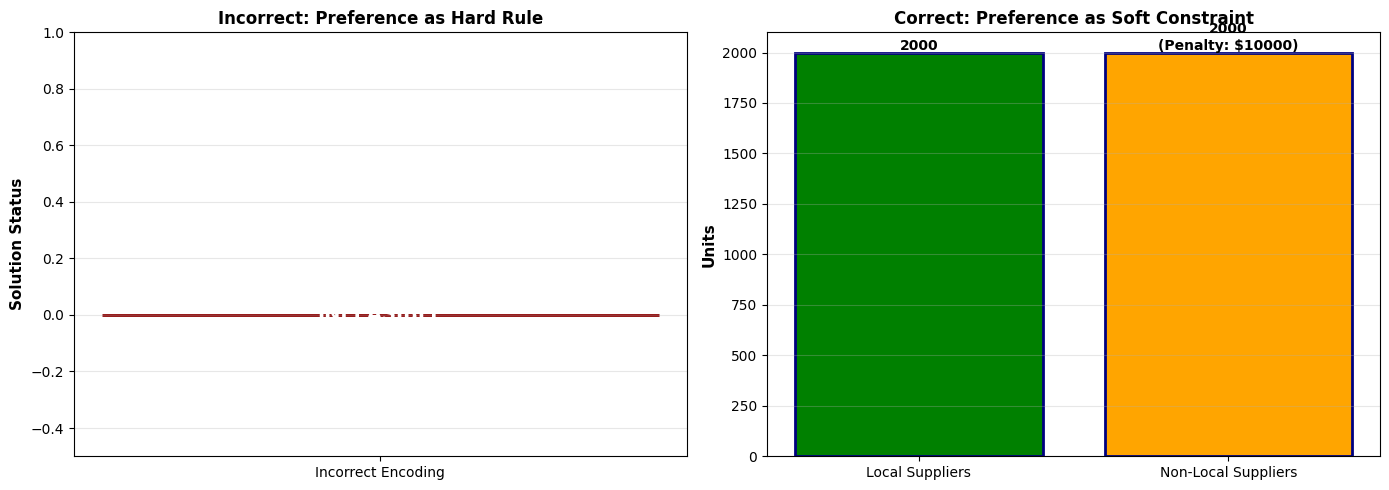


Key Insights:
  - Incorrect encoding (preference as rule) → Model infeasible
  - Correct encoding (preference as soft constraint) → Model finds solution
  - Penalty reflects the importance of the preference
  - Correct encoding matches business reality: prefer local, but allow non-local


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calculate local vs non-local for correct encoding
local_units = sum([value(use_correct[i]) for i in range(n_suppliers) 
                   if supplier_data[suppliers[i]]['local']])
non_local_units = required_units - local_units

# Plot 1: Incorrect encoding result
axes[0].bar(['Incorrect Encoding'], [0], color='red', edgecolor='darkred', linewidth=2)
axes[0].text(0, 0, 'INFEASIBLE', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
axes[0].set_ylabel('Solution Status', fontsize=11, fontweight='bold')
axes[0].set_title('Incorrect: Preference as Hard Rule', fontsize=12, fontweight='bold')
axes[0].set_ylim(-0.5, 1)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Correct encoding result
axes[1].bar(['Local Suppliers', 'Non-Local Suppliers'], 
            [local_units, non_local_units],
            color=['green', 'orange'], edgecolor='navy', linewidth=2)
axes[1].set_ylabel('Units', fontsize=11, fontweight='bold')
axes[1].set_title('Correct: Preference as Soft Constraint', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].text(0, local_units, f'{local_units:.0f}', ha='center', va='bottom', fontweight='bold')
axes[1].text(1, non_local_units, f'{non_local_units:.0f}\n(Penalty: ${total_penalty_val:.0f})', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Incorrect encoding (preference as rule) → Model infeasible")
print("  - Correct encoding (preference as soft constraint) → Model finds solution")
print("  - Penalty reflects the importance of the preference")
print("  - Correct encoding matches business reality: prefer local, but allow non-local")


## Summary: Understanding Policy Realism

**Policy Realism** requires correct encoding:
- Rules must be hard constraints (cannot violate)
- Preferences must be soft constraints with penalties (can violate)
- Incorrect encoding makes models infeasible or dangerous

**Key Takeaways**:
- Treating preferences as rules makes models infeasible
- Treating rules as preferences makes models recommend illegal solutions
- Correct encoding produces usable recommendations
- Understanding policy realism is essential for building practical models
